### Will a Customer Accept the Coupon?

**Context**

Imagine driving through town and a coupon is delivered to your cell phone for a restaraunt near where you are driving. Would you accept that coupon and take a short detour to the restaraunt? Would you accept the coupon but use it on a sunbsequent trip? Would you ignore the coupon entirely? What if the coupon was for a bar instead of a restaraunt? What about a coffee house? Would you accept a bar coupon with a minor passenger in the car? What about if it was just you and your partner in the car? Would weather impact the rate of acceptance? What about the time of day?

Obviously, proximity to the business is a factor on whether the coupon is delivered to the driver or not, but what are the factors that determine whether a driver accepts the coupon once it is delivered to them? How would you determine whether a driver is likely to accept a coupon?

**Overview**

The goal of this project is to use what you know about visualizations and probability distributions to distinguish between customers who accepted a driving coupon versus those that did not.

**Data**

This data comes to us from the UCI Machine Learning repository and was collected via a survey on Amazon Mechanical Turk. The survey describes different driving scenarios including the destination, current time, weather, passenger, etc., and then ask the person whether he will accept the coupon if he is the driver. Answers that the user will drive there ‘right away’ or ‘later before the coupon expires’ are labeled as ‘Y = 1’ and answers ‘no, I do not want the coupon’ are labeled as ‘Y = 0’.  There are five different types of coupons -- less expensive restaurants (under \\$20), coffee houses, carry out & take away, bar, and more expensive restaurants (\\$20 - \\$50). 

**Deliverables**

Your final product should be a brief report that highlights the differences between customers who did and did not accept the coupons.  To explore the data you will utilize your knowledge of plotting, statistical summaries, and visualization using Python. You will publish your findings in a public facing github repository as your first portfolio piece. 





### Data Description
Keep in mind that these values mentioned below are average values.

The attributes of this data set include:
1. User attributes
    -  Gender: male, female
    -  Age: below 21, 21 to 25, 26 to 30, etc.
    -  Marital Status: single, married partner, unmarried partner, or widowed
    -  Number of children: 0, 1, or more than 1
    -  Education: high school, bachelors degree, associates degree, or graduate degree
    -  Occupation: architecture & engineering, business & financial, etc.
    -  Annual income: less than \\$12500, \\$12500 - \\$24999, \\$25000 - \\$37499, etc.
    -  Number of times that he/she goes to a bar: 0, less than 1, 1 to 3, 4 to 8 or greater than 8
    -  Number of times that he/she buys takeaway food: 0, less than 1, 1 to 3, 4 to 8 or greater
    than 8
    -  Number of times that he/she goes to a coffee house: 0, less than 1, 1 to 3, 4 to 8 or
    greater than 8
    -  Number of times that he/she eats at a restaurant with average expense less than \\$20 per
    person: 0, less than 1, 1 to 3, 4 to 8 or greater than 8
    -  Number of times that he/she goes to a bar: 0, less than 1, 1 to 3, 4 to 8 or greater than 8
    

2. Contextual attributes
    - Driving destination: home, work, or no urgent destination
    - Location of user, coupon and destination: we provide a map to show the geographical
    location of the user, destination, and the venue, and we mark the distance between each
    two places with time of driving. The user can see whether the venue is in the same
    direction as the destination.
    - Weather: sunny, rainy, or snowy
    - Temperature: 30F, 55F, or 80F
    - Time: 10AM, 2PM, or 6PM
    - Passenger: alone, partner, kid(s), or friend(s)


3. Coupon attributes
    - time before it expires: 2 hours or one day

### Import relavent libraries

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
pd.set_option('display.max_columns', None)
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
import plotly.graph_objects as go

In [23]:
#code to disable auto scrolling

In [24]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

<b>Helper Function(s)</b> to filter dataframe with combinations of various features and its values. 

In [149]:
def barchart(df,target_var='',descending = False,showlegend = True, showFeature=True):
    """ Function to take a dataframe and return a barchart object
    
    Args:
        df: DataFrame 
        target_var: If Y, then both Accepted Rate (Y1) and Reject Rate (Y0) are returned
                    If Y0, then only Reject Rate (Y0) is returned
                    If Y1, then only Accept Rate (Y1) is returned
    Returns: 
        plotly barchart
    """
    target_key = list(target_var.keys())[0]
    target_val = target_var[target_key]
    columns = columns=['Percentage','Feature Value', 'Numeric Value','Feature Value 2','Row Count','target val']
    
    df0 = pd.DataFrame(columns=columns)
    df1 = pd.DataFrame(columns=columns)

    df0['Percentage'] = df['Negative Rate']
    df0['Feature'] = df['Feature Value']
    df0['Feature Value'] = target_key + ' = 0 : ' + df['Feature Value']
    df0['Filter'] =  df['Numeric Value']
    df0['Row Count'] =  df['Negative Count']
    df0['target val'] =  target_key + ' = 0'
    
    df1['Percentage'] = df['Positive Rate']
    df1['Feature'] = df['Feature Value']
    df1['Feature Value'] = target_key + ' = 1 : ' + df['Feature Value']
    df1['Filter'] =  df['Numeric Value']
    df1['Row Count'] =  df['Positive Count']
    df1['target val'] =  target_key + ' = 1'
        
    hover_data = {'Percentage':True,'Row Count':True,'Filter':True,'Feature Value':False,'target val':True}
    if(target_val == ''):
        hover_data['target val'] = False
        df = pd.concat([df1,df0])
        if(showFeature == False):
            hover_data['Feature Value'] = True
            fig = px.bar(df, x='target val', y=df.columns[0], color='target val',hover_data=hover_data,text='Row Count')
        else:
            df.sort_values(by='Feature Value')
            fig = px.bar(df, x='Feature Value', y=df.columns[0], color='Feature',hover_data=hover_data,text='Row Count')
    elif(target_val == '0'):
        df = df0
        fig = px.bar(df, x='Feature', y=df.columns[0], color='Feature', hover_data=hover_data,text='Row Count')
    elif(target_val == '1'):
        df = df1
        fig = px.bar(df, x='Feature', y=df.columns[0], color='Feature', hover_data=hover_data,text='Row Count')
    
    #fig.update_traces(hovertemplate = "Feature:%{label}: <br>Percentage:%{value}</br>Filters:%{custom_data}")
    #fig.update_traces(hovertemplate = "</br> Percentage:%{value} </br> Filters:%{customdata}")
    
    fig.update_layout(width=1200,height=800)
    if(descending == True):
        fig.update_xaxes(categoryorder="total descending")
        #fig.update_layout(width=900,height=500)
    fig.update_layout(yaxis_ticksuffix="%",showlegend=showlegend)
    fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
    fig.for_each_trace(lambda t: t.update(hovertemplate=t.hovertemplate.replace("sum of", "")))
    return fig

In [150]:
#Function to return top n correlating features:
def top_correlation (df,n,ascending):
    corr_matrix = df.corr()
    correlation = (corr_matrix.abs().where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
                 .stack()
                 .sort_values(ascending=ascending))
    corr_df = pd.DataFrame(correlation).reset_index()
    corr_df.columns=["Feature 1","Feature 2","Correlation"]
    corr_df = corr_df.reindex(corr_df.Correlation.abs().sort_values(ascending=ascending).index).reset_index().drop(["index"],axis=1)
    return corr_df.head(n)

In [151]:
# Function to enclose a list into another list. Since assigning a list directly to a column in DataFrame spreads 
#the values into myltiple rows, we need to enclose the list into another list so it can be assigned to one row in the DF.
def extractSubList(lst):
    return [[element] for element in lst]

In [152]:
# Function to unwrap elements of list of items within another list
def returnSubList(lst):
    if(isinstance(lst[0],list)):
        return lst[0]
    else:
        return lst    

In [153]:
# Creates a dataframe by Feature value when more than one feature against the target variable, in this case coupon 
#acceptance
def dfbyfeature(df,fv = ''):
    cols = df.columns[[0,1,2,3,4,5]]
    df1 = pd.DataFrame(columns=cols)
    row = df.iloc[:1]
    df1[cols[0]] = row[cols[0]]
    df1[cols[1]] = row[cols[1]]
    df1[cols[2]] = row[cols[2]]

    if(fv != ''):
        df1[cols[3]] = fv
    else:
        df1[cols[3]] = ' (&) '.join(df[cols[3]])
    df1[cols[4]] = row[cols[4]]
    df1[cols[5]] = row[cols[5]]
    return df1 

In [154]:
# Filter input dataframe based on various categorical and numeric features and return the filtered dataframe 
# and an optional second dataframe to hold the acceptance rate. Filter condition takes the non tranformed input data.

def Filter_Dataframe(df,categorical_values, numeric_values='', target_var=''):
    """ Function to take a dataframe and categorical features as filter and return two dataframes:
            1) Filtered DataFrame 
            2) Acceptance and Rejection Rates DataFrame
    Args:
        df: Transformed DataFrame where categorical features are transformed values.
        categorical_values: Filter conditions for categorical features.
        numeric_values: Filter conditions for numeric features
        target_var: Flag to calculate acceptance and/or rejection rate; Y0 for reject rate, Y1 for accept rate and Y for both
    Returns: 
        Two dataframes; one with filtered values and another with accept and/or reject rate
    """
    categories_keys = [] 
    category_vals = []
    multipleKeys = True
    
    if(len(categorical_values.keys()) == 1):
        item = categorical_values[list(categorical_values.keys())[0]]
        if (item == '' or item == []):
            multipleKeys = False
    
    for key in categorical_values.keys():
        item = categorical_values[key]
        if (item == '' or item == []):
            category_vals.extend(list(orig_col_vals[key].keys()))
            item = list(orig_col_vals[key].values())
            categories_keys.extend([key] * len(item))
        else:
            category_vals.append(item) # add it as list of list so dataframe won't break it into multiple rows
            item = [orig_col_vals[key][i] for i in item if i in orig_col_vals[key]]
            categories_keys.append(key)
        categorical_values[key] = item
    category_vals = extractSubList(category_vals)
    
    #Form the query based on all theinput conditions from categorical and numeric features. 
    query = [f"{col} in {val}" for col, val in categorical_values.items()]
    query = ' & '.join(query)
    query2 = 'N'
    if (numeric_values != ''):
        query2 = [f"{col}{val}" for col, val in numeric_values.items()]
        query2 = ' & '.join(query2)
        query += '&'+ query2
    
    target_key = list(target_var.keys())[0]
    target_val = target_var[target_key]
    if(target_val != ''):
        query += ' & ' + target_key + '== ' + target_val
    
    df_filtered = df.query(query)
    df_filtered['Numeric Value'] = query2
    
    # Frame the Acceptance and Rejection rate DataFrame
    df_acc_rate = pd.DataFrame(columns=['Positive Rate','Negative Rate','Numeric Value','Feature Value','Positive Count','Negative Count','Category','Value(s)','Transformed vals','Value Counts'])
    df_acc_rate['Category'] = categories_keys
    df_acc_rate['Value(s)'] = category_vals
    df_acc_rate['Value(s)'] = df_acc_rate['Value(s)'].apply(returnSubList)
    df_acc_rate['Numeric Value'] = query2
    
    rows = df.shape[0]
    
    for index, row in df_acc_rate.iterrows():
        
        if(multipleKeys == False):
            row['Feature Value'] = ','.join(row['Value(s)'])
        else:
            row['Feature Value'] = '<b>' + row['Category'] + '</b>' + ' in ' + ','.join(row['Value(s)']) # to show the feature value from multiple input feature
        category = row['Category']
        category_vals = row['Value(s)']
        category_Transformed_vals = [orig_col_vals[category][i] for i in category_vals]
        row['Transformed vals'] = category_Transformed_vals
        row['Value Counts'] = data_copy[category].unique()
        
        positive_row_cnt = df_filtered.query('{2} == 1 & {0} in {1} '.format(category,category_Transformed_vals,target_key)).shape[0]
        negative_row_cnt = df_filtered.query('{2} == 0 & {0} in {1} '.format(category,category_Transformed_vals,target_key)).shape[0]
        row['Negative Count'] = negative_row_cnt
        row['Negative Rate'] = round(negative_row_cnt / rows * 100,2)
        row['Positive Count'] = positive_row_cnt
        row['Positive Rate'] = round(positive_row_cnt / rows * 100,2) 
    #df_acc_rate = df_acc_rate.sort_values(by='Feature Value')
    return df_filtered,df_acc_rate    

### Problems

Use the prompts below to get started with your data analysis.  

##### 1. Read in the `coupons.csv` file.




In [155]:
data = pd.read_csv('data/coupons.csv')

#####  2. Investigate the dataset for missing or problematic data.

Feature <b>"Age"</b> has two distinct values as "50plus" and "below21". We can use the numeric values <b>51</b> for "50plus" and <b>20</b> for "below 21" so this column can be converted to numeric datatype

In [156]:
data['age']  = data['age'].replace({'50plus':'51','below21':'20'}).apply(pd.to_numeric)

###### Get information about missing values of each column

Calculate the percentage of <b>missing</b> values and the most recurring value <b>(mode) </b>
for each of those features that are missing values.

In [157]:
#percentage of missing values
percent_missing = round(data.isnull().sum() * 100 / len(data),2)
missing_value_df = pd.DataFrame({'column_name': data.columns,
                                 'percent_missing': percent_missing})
missing_value_df = missing_value_df[missing_value_df['percent_missing'] > 0.00]
missing_value_df.set_index('column_name')
missing_value_df.drop(columns=['column_name'],axis=1,inplace=True)

#most recurring values from each feature that are missing values.
cols = missing_value_df.index
most_recurring_vals = []
for c in cols:
    most_recurring_vals.append(data[c].value_counts().index[0])
missing_value_df['Most Recurring Value'] = most_recurring_vals

#### 3. Decide what to do about your missing data -- drop, replace, other...

Since <b>99 %</b> of values are missing in feature <b>"car"</b>, lets drop the column from the dataset.

In [158]:
missing_value_df

,percent_missing,Most Recurring Value
car,99.15,Scooter and motorcycle
Bar,0.84,never
CoffeeHouse,1.71,less1
CarryAway,1.19,1~3
RestaurantLessThan20,1.02,1~3
Restaurant20To50,1.49,less1


In [159]:
data.drop(columns=['car'], axis=1, inplace=True)
missing_value_df = missing_value_df.iloc[1:]

Feature <b>"toCoupon_GEQ5min" </b> contains only one value which is <b>1</b>. So we can drop this column as well.

In [160]:
data.drop(columns=['toCoupon_GEQ5min'], axis=1, inplace=True)

Features <b>direction_same</b> and <b>direction_opp</b> are mutually exclusive. So we can drop one of them. Lets drop <b>direction_opp</b>.

In [161]:
data.drop(columns=['direction_opp'], axis=1, inplace=True)

Populate the most recurring values <b>(mode)</b> for each feature that are <b>still missing</b> values

In [162]:
for rec_val in missing_value_df.index:
    data[rec_val] = data[rec_val].fillna(missing_value_df['Most Recurring Value'][rec_val])

Make a copy of the original Dataframe before transforming the <b>categorical</b> features.

In [163]:
data_copy = data.copy()

<b>Transform</b> the <b>categorical</b> variables to <b>numeric</b> to be used for further analysis

Store the <b>original values</b> of features values before transformation.

In [164]:
orig_col_vals = {}

In [165]:
from sklearn import preprocessing

Categorical_Colums = data.select_dtypes(include=['object']).columns.tolist()
le = preprocessing.LabelEncoder()
for column in Categorical_Colums:
    orig_col_vals[column] = {}
    data[column] = le.fit_transform(data[column])
    orig_col_vals[column] = dict(zip(le.classes_, le.transform(le.classes_)))    

Lets perform a <b>Simple Logistic Regression</b> to understand the significance <b>(p-values)</b> of features and its <b>coefficient</b> so we can explore these features further in this task.

In [166]:
import statsmodels.api as sm

In [167]:
#declare independent (y) variables and dependent (x1) variables
y = data['Y']
x1 = data.drop(columns=['Y','coupon'],axis=1)

In [168]:
x = sm.add_constant(x1)  #add constant (intercept)
reg_log = sm.Logit(y,x) #regression
results_log = reg_log.fit()

summary_df = pd.DataFrame(data=x1.columns.tolist(), columns=['Features'])
summary_df.set_index('Features')
summary_df['p-values'] = np.array(round(results_log.pvalues.iloc[1:],3).tolist(), dtype=float)
summary_df['coeff'] = np.array(round(results_log.params.iloc[1:],3).tolist(), dtype = float)

Optimization terminated successfully.
         Current function value: 0.646121
         Iterations 5


In [169]:
# Get top 6 Features which we can explore later
summary_df = summary_df[summary_df['p-values'] <= 0.05].sort_values(by='p-values', ascending=True)
summary_df.set_index('Features',inplace=True)

In [170]:
summary_df.head(2)

,p-values,coeff
Features,,
destination,0.0,0.124
toCoupon_GEQ15min,0.0,-0.186


<b>Heatmap<b/> of correlation matrix

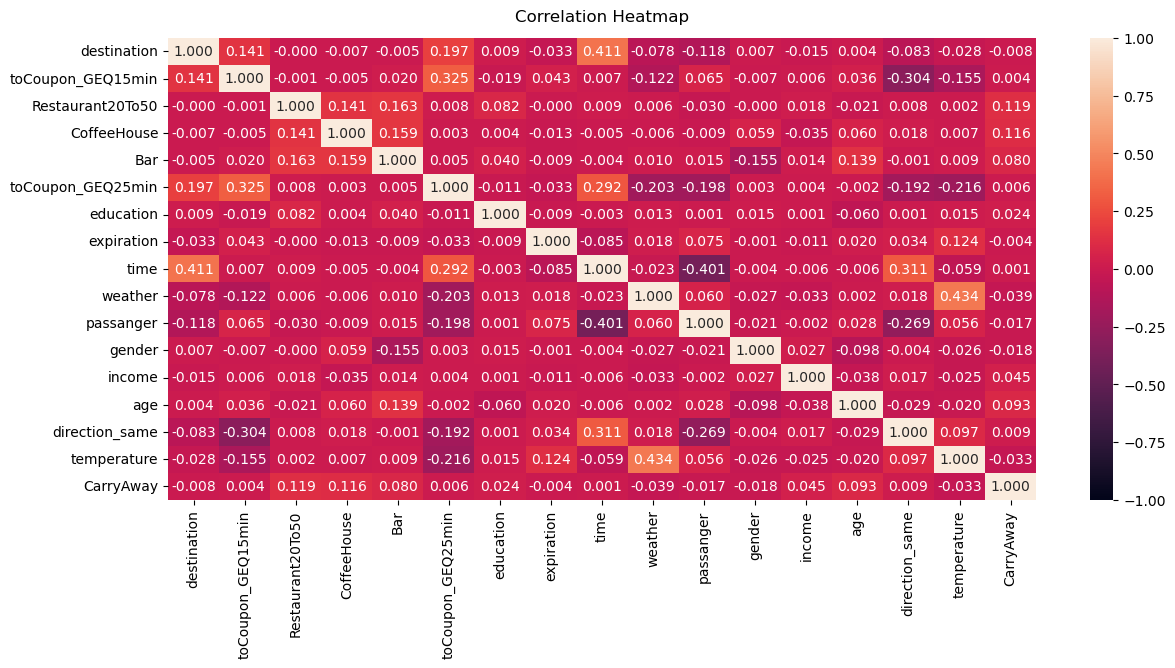

In [171]:
lstcols = summary_df.index.tolist()
df_significant_features = data[lstcols]
plt.figure(figsize=(14, 6))
heatmap = sns.heatmap(df_significant_features.corr(), vmin=-1, vmax=1, annot=True, fmt='.3f') #round to 3 decimal places
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

Top <b>3</b> correlating features

In [172]:
top_correlation(df_significant_features,3, False)

,Feature 1,Feature 2,Correlation
0,weather,temperature,0.434497
1,destination,time,0.411437
2,time,passanger,0.400690


In [173]:
#Declare target variables
Y0 = {'Y':'0'}
Y1 = {'Y':'1'}
Y = {'Y':''}

#### 4. What proportion of the total observations chose to accept the coupon? 



In [174]:
coupon_acceptance_percentage = round((data.query('Y == 1').shape[0] / data.shape[0]) * 100, 2)
print('Proportion of total observations that chose to accept coupon is {0} %'.format(coupon_acceptance_percentage))

Proportion of total observations that chose to accept coupon is 56.84 %


#### 5. Use a bar plot to visualize the `coupon` column.

In [175]:
df = Filter_Dataframe(data,{'coupon':[]},'',Y)[1]
barchart(df,Y).show()

<b>Finding</b> - The number of <b>Coffee house</b> coupons are much more than other coupons

#### 6. Use a histogram to visualize the temperature column.

In [176]:
fig = px.histogram(data_frame=data_copy, x='temperature', color=data_copy['Y'].map({0:'Not Accepted',1:'Accepted'}))
fig.update_layout(width=900,height=400)
fig.show()

**Investigating the Bar Coupons**

Now, we will lead you through an exploration of just the bar related coupons.  

#### 1. Create a new `DataFrame` that contains just the bar coupons.


In [177]:
bar_df = data[data['coupon'] == orig_col_vals['coupon']['Bar']]

#### 2. What proportion of bar coupons were accepted?


In [178]:
bar_coupon_acceptance_percentage = round((bar_df.query('Y == 1').shape[0] / bar_df.shape[0]) * 100, 2)
print('Proportion of bar coupons were accepted is {0} %'.format(bar_coupon_acceptance_percentage))

Proportion of bar coupons were accepted is 41.0 %


<b>Finding</b> - Proportion of bar coupons were accepted is <b>41.0 %</b>. 

#### 3. Proportion of bar coupons accepted and rejected by various features.

In [179]:
df1 = Filter_Dataframe(bar_df,{'maritalStatus':[],'passanger':[],'time':[],'weather':[],'gender':[],'education':[]},'',Y)[1]
fig = barchart(df1,Y,showlegend=False)
fig.update_layout(title='Acceptance and Rejection Rates of coupons by various Features')
fig.show()

#### 4. Proportion of bar coupons accepted by driver's destination and if the coupon venue is in the same direction as that of destination.

In [180]:
bar_df.query('destination == "No Urgent Place" & direction_same == 0').shape[0]

0

In [181]:
df1 = Filter_Dataframe(bar_df,{'destination':[]},{'direction_same' : '==0'},Y)[1]
df2 = Filter_Dataframe(bar_df,{'destination':[]},{'direction_same' : '==1'},Y)[1]
barchart(pd.concat([df1,df2]),Y).show()

<b>Finding</b> - The following are the analysis of the acceptance rate of drivers travelling to their destination and whether the venue of the coupon in the same direction

- Drivers not travelling to any <b>urgent place</b> has the highest acceptance rate at <b> 20.72 %</b> when the venue is in the opposite direction as that of destination.
- Drivers travelling <b>home</b> has a <b>8.28 %</b> acceptance rate when the venue is in the same direction. If the venue is in the opposite direction, then the acceptance rate drops to <b>3.17 %</b>
- Drivers travelling to <b>Work</b> has a <b>1.29 %</b> acceptance rate when the venue is in the same direction. If the venue is in the opposite direction, then the acceptance increases to <b>7.54 %</b>


#### 5. Compare the acceptance rate between those who went to a bar 3 or fewer times a month to those who went more.


Feature <b>"Bar"</b> has a value called <b>"never"</b>. What this means is that, the driver <b>never</b> goes to bar. However, in order to decide whether to include this value for the forthcoming analysis, check if there are rows where <b>Bar == 'never'</b> and coupon accepted = <b>'Y'</b>. If such rows exists, then we will consider this value.

In [182]:
bar_never_accepted_coupon = Filter_Dataframe(bar_df,{'Bar':['never']},'',Y1)[0].shape[0]
bar_never_accepted_coupon

164

Since there are <b>164</b> records, we will keep this value and tag is against drivers going to bar less than 1.

In [183]:
bar_3_or_less = ['never','less1','1~3']
bar_more_than_3 = ['4~8','gt8']

In [184]:
df_bar_3_or_less = dfbyfeature(Filter_Dataframe(bar_df,{'Bar':bar_3_or_less},'',Y)[1],'Bar <= 3 times / month')
df_bar_more_than_3 = dfbyfeature(Filter_Dataframe(bar_df,{'Bar':bar_more_than_3},'',Y)[1],'Bar > 3 times / month')
barchart(pd.concat([df_bar_3_or_less,df_bar_more_than_3]),Y).show()

<b>Finding</b> - Acceptance rate of drivers going to bar <b>less than 3 times</b> a month has the highest rate at <b>33.42 %</b> than the drivers who went to bar <b>more than 3 times</b> a month having the acceptance rate of <b>7.59 %</b>. 

#### 6. Compare the acceptance rate between drivers who go to a bar more than once a month and are over the age of 25 to the all others.  Is there a difference?


In [185]:
bar_more_than_1_month = ['1~3','4~8','gt8']
bar_less_than_1_month = list(set(list(data_copy['Bar'].unique())) - set(bar_more_than_1_month))

In [186]:
df_bar_more_than_1_over_25yrs = dfbyfeature(Filter_Dataframe(bar_df,{'Bar':bar_more_than_1_month},{'age':'>25'},Y1)[1], 'Bar > 1 times / month')
df_bar_less_than_1_over_25yrs = dfbyfeature(Filter_Dataframe(bar_df,{'Bar':bar_less_than_1_month},{'age':'>25'},Y1)[1], 'Bar < 1 time / month')
df_bar_more_than_1_under_25yrs = dfbyfeature(Filter_Dataframe(bar_df,{'Bar':bar_more_than_1_month},{'age':'<=25'},Y1)[1], 'Bar > 1 times / month')
df_bar_less_than_1_under_25yrs = dfbyfeature(Filter_Dataframe(bar_df,{'Bar':bar_less_than_1_month},{'age':'<=25'},Y1)[1], 'Bar < 1 time / month')
barchart(pd.concat([df_bar_more_than_1_over_25yrs,df_bar_less_than_1_over_25yrs,df_bar_more_than_1_under_25yrs,df_bar_less_than_1_under_25yrs]),Y1).show()

<b>Finding</b> - Bar coupon acceptance rate for drivers with age <b>over or under 25 yrs old</b> is almost the same between driver going to bar more or less than once a month. 

#### 7. Use the same process to compare the acceptance rate between drivers who go to bars more than once a month and had passengers that were not a kid and had occupations other than farming, fishing, or forestry. 


In [187]:
acc_rate_with_kids = (Filter_Dataframe(bar_df,{'passanger':'Kid(s)'},'',Y1)[1])['Positive Rate']
print('Proportion of observations that chose to accept coupon having passanger as kids is {0} %'.format(acc_rate_with_kids))

Proportion of observations that chose to accept coupon having passanger as kids is 0    0.0
Name: Positive Rate, dtype: object %


<b>Finding</b> - No bar coupons were accepted by the drivers having <b>kids</b> as passanger

<b>Visualize the acceptance and rejection rate by occupation</b>

In [188]:
fig = barchart(Filter_Dataframe(bar_df,{'occupation':[]},'',Y)[1], Y,showlegend=False)
fig.update_layout(title='Acceptance rate of coupons by occupation')
fig.show()

<b>Finding</b> - <b>Student</b>, <b>Unemployed</b> and <b>Computer and mathematics profession </b> have the highest acceptance rate for coupon at <b>6% , 5%</b> and <b>4%</b> respectively.

In [189]:
bar_unique_vals = list(data_copy['Bar'].unique())
bar_less_than_a_month = ['never', 'less1']
no_kids = list(data_copy['passanger'].unique())
no_kids.remove('Kid(s)')

Lets remove occupations <b>Student</b>, <b>Unemployed</b> and <b>Retired</b> as these belong to not working category.
Since there are no coupons accepted with <b>Kid(s)</b> as a passanger, this feature will not have a value.

In [190]:
lst_notworking = ['Student','Unemployed','Retired']
lst_all = list(data_copy['occupation'].unique())
lst_working = list(set(lst_all) - set(lst_notworking))

In [191]:
df1 = dfbyfeature(Filter_Dataframe(bar_df,{'occupation':lst_working},{'age':'<= 25'},Y)[1],'Working and age < 25')
df2 = dfbyfeature(Filter_Dataframe(bar_df,{'occupation':lst_working},{'age':'> 25'},Y)[1],'Working and age >= 25')
barchart(pd.concat([df1,df2]), Y).show()

<b>Finding</b> - Drivers who are <b>working</b> and over 25 years old had a much higher <b>(24 %)</b> acceptance rate than drivers who are <b>working</b> and under 25 years old <b>(5%)</b>.

#### 6. Compare the acceptance rates between those drivers who:

- go to bars more than once a month, had passengers that were not a kid, and were not widowed *OR*
- go to bars more than once a month and are under the age of 30 *OR*
- go to cheap restaurants more than 4 times a month and income is less than 50K. 



In [192]:
#maritalStatus
lst_notwidow = list(data_copy['maritalStatus'].unique())
lst_notwidow.remove('Widowed')
#RestaurantLessThan20
cheap_rest_more_than_4_times = ['4~8','gt8']
cheap_rest_less_than_4_times = list(set(list(data_copy['RestaurantLessThan20'].unique())) - set(cheap_rest_more_than_4_times))
#income
income_less_than_50k = ['Less than $12500','$12500 - $24999','$25000 - $37499','$37500 - $49999']
income_more_than_50k = list(set(list(data_copy['income'].unique())) - set(income_less_than_50k))

In [193]:
pd.set_option('display.max_columns', None)
#go to bars more than once a month, had passengers that were not a kid, and were not widowed
df1 = dfbyfeature(Filter_Dataframe(bar_df,{'Bar':bar_more_than_1_month,'passanger':no_kids,'maritalStatus':lst_notwidow},'',Y1)[1],'Bar > 4 times and not a widow')
#go to bars more than once a month and are under the age of 30
df2 = dfbyfeature(Filter_Dataframe(bar_df,{'Bar':bar_more_than_1_month},{'age':'<30'},Y1)[1],'Bar > 4 times and age < 30')
#go to cheap restaurants more than 4 times a month and income is less than 50K
df3 = dfbyfeature(Filter_Dataframe(bar_df,{'RestaurantLessThan20':cheap_rest_more_than_4_times,'income':income_less_than_50k},'',Y1)[1],'Cheap restaurant > 4 times and income < 50k ')
barchart(pd.concat([df1,df2,df3]), Y1).show()

<b> Finding </b> - Accetance rate for drivers going to bar more than 4 times is higher when the driver is not a widow. 

#### 7.  Based on these observations, what do you hypothesize about drivers who accepted the bar coupons?

1) Drivers who are over 25 year old generally accepted more coupons that drivers under 25 years old.
2) Drivers who travelled alone accepted more coupons than travelling with others.
3) Drivers who are students or unemployed accepted more coupons than other drivers in other occupations.
4) Single and Married Partners accepted the most coupons.
4) No significant difference in acceptance rate between drivers going to bar more than or less than once a month having kids as passanger at the time of receiving (accepting) the coupon.
6) Drivers not going to an urgent place accept more coupons than others.

### Independent Investigation

Using the bar coupon example as motivation, you are to explore one of the other coupon groups and try to determine the characteristics of passengers who accept the coupons.  

**Investigating the restaurant Coupon**

#### 1. Create a new `DataFrame` that contains just the restaurant coupons.

In [194]:
df_exp_rest = data[data['coupon'] == orig_col_vals['coupon']['Restaurant(20-50)']]

#### 2. What proportion of bar coupons were accepted?

In [195]:
rest_coupon_acceptance_percentage = round((df_exp_rest.query('Y == 1').shape[0] / df_exp_rest.shape[0]) * 100, 2)
print('Proportion of expensive restaurant coupons were accepted is {0} %'.format(rest_coupon_acceptance_percentage))

Proportion of expensive restaurant coupons were accepted is 44.1 %


#### 3. Proportion of restaurant coupon accepted and rejected by various features.

In [196]:
rest_median_age = str(int(df_exp_rest['age'].median()))

In [197]:
df1 = Filter_Dataframe(df_exp_rest,{'maritalStatus':[],'passanger':[],'time':[],'weather':[],'gender':[],'education':[]},'',Y)[1]
fig = barchart(df1,Y,showlegend=False)
fig.update_layout(title='Acceptance and Rejection Rates of expensive restaurant coupons by various Features')
fig.show()

#### 3. Compare the acceptance rate between those who went to a restaurant 3 or fewer times a month to those who went more.

In [198]:
rest_more_3 = ['4~8','gt8']
rest_less_3 = list(set(list(data_copy['Restaurant20To50'].unique())) - set(rest_more_3))
df1 = dfbyfeature(Filter_Dataframe(df_exp_rest,{'Restaurant20To50':rest_more_3},{'age':'>' +rest_median_age},Y1)[1],'More than 3 times / month')
df2 = dfbyfeature(Filter_Dataframe(df_exp_rest,{'Restaurant20To50':rest_more_3},{'age':'<=' + rest_median_age},Y1)[1],'More than 3 times / month')
df3 = dfbyfeature(Filter_Dataframe(df_exp_rest,{'Restaurant20To50':rest_less_3},{'age':'>' + rest_median_age},Y1)[1],'Less than 3 times / month')
df4 = dfbyfeature(Filter_Dataframe(df_exp_rest,{'Restaurant20To50':rest_less_3},{'age':'<=' + rest_median_age},Y1)[1],'Less than 3 times / month')
barchart(pd.concat([df1,df2,df3,df4]),Y1).show()

<b>Finding</b> - Drivers who went to restaurant <b>more than 3 times a month</b> accepted <b>fewer</b> coupons (5.3 %) than drivers who went <b>less than 3 times</b> (39 %). 

Drivers with age <b>over</b> the median age of <b>31</b> accepted <b>less</b> coupons than drivers <b>under 31</b>. 

Since drivers who went to resturant <b>less than 3 times</b> accepted more coupons, lets include other features to this data 
to see how the acceptance rate is affected.

Check the income distribution of drivers who goes to restaurant less than 3 times a month and accepting coupon

In [199]:
df = Filter_Dataframe(df_exp_rest,{'Restaurant20To50':rest_less_3},'',Y1)[0]
df1 = Filter_Dataframe(df,{'income':income_less_than_50k},'',Y1)[1]
df2 = Filter_Dataframe(df,{'income':income_more_than_50k},'',Y1)[1]
barchart(pd.concat([df1,df2]), Y1).show()

<b>Finding</b> - The acceptance rate of drivers who go to restaurant less than 3 times a month with income 75000 is <b>50.95 %</b> and with income 12500 is <b>49 %</b>. 
    There is no big difference in acceptance rate between low and high earning drivers.                                   

#### 4. Compare the acceptance rate of drivers who went to restaurant less than 3 times a month based on their occupation

In [200]:
df1 = Filter_Dataframe(df_exp_rest,{'Restaurant20To50':rest_less_3},'',Y1)[0]
barchart(Filter_Dataframe(df1,{'occupation':[]},'',Y1)[1], Y1, showlegend=False).show()

<b>Finding</b> - Drivers with computer related occupation accepted most of the coupons. Also drivers who are student and unemployed (non working categories) appeared second in the acceptance rate of the coupon.

##### 5. Compare the acceptance rate of drivers going to restaurant less than 3 times a month against their working status. 
###### We will consider students and unemployed as not working and other occupations as working.

In [201]:
lstunemployed = ['Unemployed','Student']
lstemployed = list(data_copy['occupation'].unique())
lstemployed = list(set(lstemployed) - set(lstunemployed))

In [202]:
df1 = dfbyfeature(Filter_Dataframe(df_exp_rest,{'Restaurant20To50':rest_less_3,'occupation':lstemployed},'',Y1)[1], 'Working')
df2 = dfbyfeature(Filter_Dataframe(df_exp_rest,{'Restaurant20To50':rest_less_3,'occupation':lstunemployed},'',Y1)[1], 'Not Working')
barchart(pd.concat([df1,df2]),Y1).show()

<b>Finding - </b>Drivers who went to restaurant <b>less than 3 times</b> and are <b>employed</b> accepted more coupons (29%) than drivers who are either unemployed or a student (9%).

#### 6. Compare the acceptance rate of drivers going to restaurant less than 3 times a month against the proximity of their destination to the restaurant venue. 
###### Here, value 1 indicates time to venue is within the given minute and 0 indicates time to venue is not within the given minute.



 - direction_same = 0 means opposite direction
 - direction_same = 1 means same direction

In [203]:
df1 = dfbyfeature(Filter_Dataframe(df_exp_rest,{'Restaurant20To50':rest_less_3},{'toCoupon_GEQ25min': '==0','toCoupon_GEQ15min': '==1','direction_same':'==0'},Y1)[1],'Opposite Direction')
df2 = dfbyfeature(Filter_Dataframe(df_exp_rest,{'Restaurant20To50':rest_less_3},{'toCoupon_GEQ25min': '==0','toCoupon_GEQ15min': '==1','direction_same':'==1'},Y1)[1],'Same Direction')
barchart(pd.concat([df1,df2]),Y1).show()

<b>Finding</b> - Drivers going in opposite direction with distance to venue less than 15 mins accepted more coupons <b>(20%)</b> than drivers travelling in same direction <b>(1%)</b>. 

This is because all drivers going <b>home</b> as their destination aren't accepting many coupons 

In [204]:
df1 = dfbyfeature(Filter_Dataframe(df_exp_rest,{'Restaurant20To50':rest_less_3},{'toCoupon_GEQ25min': '==1','direction_same':'==0'},Y1)[1],'Opposite Direction')
df2 = dfbyfeature(Filter_Dataframe(df_exp_rest,{'Restaurant20To50':rest_less_3},{'toCoupon_GEQ25min': '==1','direction_same':'==1'},Y1)[1],'Same Direction')
barchart(pd.concat([df1,df2]),Y1).show()

<b>Finding</b> - Drivers going in opposite direction with distance to venue greater than 15 mins accepted more coupons than drivers travelling in same direction. 